Mohammad Hamza Laghari

**Problem Statement:**
XYZ is an Omni-channel retailer selling 50 different products across 10 different stores. They have sales data for all these stores & products for 5 years spanning from 2013 to 2017. XYZ is interested in forecasting sales for the next 6 months at an overall level to better improve financial planning and inventory management. XYZ has developed a vanilla ARIMA model to predict 6 months of overall sales. However they are interested in knowing if a LSTM network could be developed which can produce more accurate forecasts. For this purpose they have provided the data and the basic ARIMA model. Develop a LSTM model to forecast 6 months of overall sales and compare its performance with the ARIMA model.

Installing necessary packages to connect to google drive

In [1]:
install.packages('googledrive') 
install.packages('httpuv') 
library(googledrive) 
library(httpuv)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘promises’, ‘later’




In [2]:
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) { #may update python version  
                                       #occasionally
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.11.0 (2021-09-26 08:30:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings




We need to authenticate a connection to the course google drive that contains the data once.

After running the below script:

1) Click on the link that appears at the bottom   
2) Select the google account associated with this Colab session (The account displayed in colab at the top right!)   
3) Check all tickboxes to give R permission to download images from the drive    
4) Copy the code displayed & paste it here at the field shown & press enter

In [3]:
drive_auth(use_oob = TRUE, cache = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-dpeg5tt0et3go5of2374d83ifevk5086.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AX4XfWj4I_0YXwfqO4WA8Hj_GHIDnotwbLAVc9xsK5SGMt1ZeSoNpwuXSzM


Downloading the Store data from drive to Colab local & reading it into memory

In [4]:
#file_id <- drive_ls("~/AI_Datasets/",recursive = T,pattern = "Store",type = "csv")
#x <- drive_get(as_id(file_id))
#drive_download(x)

ERROR: ignored

Installing necessary packages

In [1]:
install.packages('forecast')
install.packages('Metrics')
install.packages('lubridate')
install.packages('keras')
library(forecast)
library(Metrics)
library(lubridate)
library(dplyr)
library(keras)
library(magrittr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘lubridate’


The following objects are masked from ‘packag

In [2]:
df <- read.csv('/content/Store_data.csv')

Since we need to forecast sales at an overall level, we first need to aggregate the data from Store, Product, Daily level to Daily level

In [3]:
##Aggregate the data to 'date' level & cast the date column to the 'date' datatype in R. 
##Dataset should only have 'date' and 'sales' columns.
drop <- c('store','item')
df2 <- df[,!(names(df) %in% drop)]
df3 <- aggregate(x = df2[c("sales")],
                     FUN = sum,
                     by = list(date = df2$date))

In [4]:
df3 %<>% mutate(df3, date= as.Date(date, format= "%Y-%m-%d"))

We need to split the data into Training and Testing subsets, to test final performance of our models. Since we mean to predict 6 months of sales, our test data will have 6 months of sales. We filter out last 6 months of sales in 2017 as test data.

In [5]:
##Split the data into Train and Test based on the condition: Train if date < "2017-07-01" & 
##Test if date >= "2017-07-01"

train<- df3[df3$date < "2017-07-01", ]
test <- df3[df3$date >= "2017-07-01", ]

The basic ARIMA model is built on the sales data in Training dataset. This will be our benchmark to improve.

In [6]:
##remove the "Month" column from Train data as it is not needed for the ARIMA model
train1 <- train[2]
test1 <- test[2]
#convert test 1 to vector
test1 <- test1[,1]

##training model
model = auto.arima(train1)

# model summary
summary(model)

Series: train1 
ARIMA(5,1,1) 

Coefficients:
          ar1      ar2      ar3      ar4      ar5      ma1
      -0.2858  -0.2987  -0.4099  -0.4630  -0.3887  -0.5977
s.e.   0.0262   0.0221   0.0202   0.0218   0.0243   0.0177

sigma^2 = 9031534:  log likelihood = -15468.4
AIC=30950.8   AICc=30950.87   BIC=30988.62

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 89.10619 2998.838 1961.687 -0.9474152 8.047087 0.6605508
                   ACF1
Training set -0.1929871

Forecasting 6 months of sales from our ARIMA model.

In [7]:
# forecasting
forecast = predict(model, length(test1))

In [8]:
length(test1)

[1] 184

Evaluating ARIMA forecast with actual sales in Test data through RMSE measure.

In [9]:
# Calculate RMSE of actual sales in Test data & Forecasted sales
rmse(actual = test1, predicted = forecast$pred)

[1] 7493.723

Redefine the training and test data with the same filter as before, inorder to build a LSTM model. We need to redefine again as we need the date column that was previous removed.

In [10]:
#Train data is data where date < "2017-07-01"
#Test data is data where date >= "2017-07-01"

train2 <-train
test2 <- test

LSTM requires the sales variable to be Standardized. Inorder to standardize we subtract the mean sales in Training data from actual sales and then divide by the Standard Deviation of sales in Training data. This is done for both Training and Test datasets

In [11]:
scale_factors <- c(mean(train2$sales), sd(train2$sales))

#Assuming that the Train dataset is named as "train" with columns "sales" & "date", we scale our sales values as
scaled_train <- train %>%
  dplyr::select(sales) %>%
  dplyr::mutate(sales = (sales - scale_factors[1]) / scale_factors[2])

#LSTM model requires a dataset which has scaled sales values for 6 months before start of Test data inorder to forecast sales for the Test data period(>= "2017-07-01")
scaled_valid <- train[train$date >= as.Date("2017-07-01") - 184,] %>%
  dplyr::select(sales) %>%
  dplyr::mutate(sales = (sales - scale_factors[1]) / scale_factors[2])

LSTM algorithm creates predictions based on the *lagged* values. That means that it needs to look back to as many previous values as many points we wish to predict. As we want to do a 6 months forecast, we need to base each prediction on 6 months worth of data points. This is the number of data points for our filter of Test data. So we lag Training values by the number of rows in our Test data.

For example, hypothetically let’s say our series has 10 data points [1, 2, 3, …, 10] and we want to predict 3 values. Then our training data looks like this:

[1, 2, 3] -> [4, 5, 6]    
[2, 3, 4] -> [5, 6, 7]   
[3, 4, 5] -> [6, 7, 8]   
[4, 5, 6] -> [7, 8, 9]   
[5, 6, 7] -> [8, 9, 10]

Predictors and target take form of:   
X =  
3 4 5 6 7                  
2 3 4 5 6   
1 2 3 4 5 
   
Y =   
6 7 8 9 10   
5 6 7 8 9   
4 5 6 7 8

Additionally keras LSTM expects specific tensor format of shape of a 3D array of the form [samples, timesteps, features] for predictors (X) and for target (Y) values:

*samples* specifies the number of observations which will be processed in batches.
*timesteps* tells us the number of time steps (lags). Or in other words how many units back in time we want our network to see.
*features* specifies number of predictors (1 for univariate series and n for multivariate).

In case of predictors that translates to an array of dimensions: (nrow(Train data) – lag – prediction + 1, nrow(Test data), 1), where lag = prediction = nrow(Test data).

In [12]:
prediction <- nrow(scaled_valid)
lag <- prediction

We lag the data nrow(scaled_valid) - 1 times, so that each prediction is based on 6 months of sales values, and arrange lagged values into columns. Then we transform it into the desired 3D form.

In [13]:
scaled_train <- as.matrix(scaled_train)

# we lag the data 183 times and arrange that into columns
x_train_data <- t(sapply(1:(length(scaled_train) - lag - prediction + 1),
                         function(x)
                           scaled_train[x:(x + lag - 1), 1]))

# now we transform it into 3D form
x_train_arr <- array(data = as.numeric(unlist(x_train_data)),
                     dim = c(nrow(x_train_data),
                             lag,
                             1))

Now we apply similar transformation for the Y values.

In [14]:
y_train_data <- t(sapply((1 + lag):(length(scaled_train) - prediction + 1),
                         function(x)
                           scaled_train[x:(x + prediction - 1)]))

y_train_arr <- array(data = as.numeric(unlist(y_train_data)),
                     dim = c(nrow(y_train_data),
                             prediction,
                             1))

In the same manner we need to prepare data for the prediction, which are in fact last 184 (6 months data) observations from our training set.

In [15]:
x_test_scaled <- scaled_valid$sales
x_pred_arr <- array(data = x_test_scaled,
                    dim = c(1,
                            lag,
                            1))

We can build a LSTM model using the keras_model_sequential function and adding layers on top of that. The first LSTM layer takes the required input shape, which is the [samples, timesteps, features]. We set for both layers return_sequences = TRUE and stateful = TRUE. The second layer is the same with the exception of batch_input_shape, which only needs to be specified in the first layer.

In [16]:
lstm_model <- keras_model_sequential()

lstm_model %>%
##Define first LSTM layer with units as 50, batch_input_shape as c(1, 184, 1) ,return_sequences = TRUE and stateful = TRUE
  layer_lstm(units = 32, return_sequences = TRUE, stateful = TRUE,
             batch_input_shape = c(1,184,1)) %>%
  # fraction of the units to drop for the linear transformation of the inputs
  layer_dropout(rate = 0.5) %>%
  ##Define second LSTM layer with units as 50, return_sequences = TRUE and stateful = TRUE
  layer_lstm(units = 50, return_sequences = TRUE, stateful = TRUE)  %>%
  layer_dropout(rate = 0.5) %>%
  time_distributed(keras::layer_dense(units = 1))

Loaded Tensorflow version 2.8.0



Also choose loss function for the optimization, type of optimizer and metric for assessing the model performance

In [17]:
#Define 'mae' as loss function, 'adam' as optimizer & 'accuracy' as metrics for the LSTM model defined previously

lstm_model %>% compile(
  optimizer = "adam", 
  loss = "mae", 
  metrics = c("acc")
)

In [18]:
summary(lstm_model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_1 (LSTM)                      (1, 184, 32)                    4352        
                                                                                
 dropout_1 (Dropout)                (1, 184, 32)                    0           
                                                                                
 lstm (LSTM)                        (1, 184, 50)                    16600       
                                                                                
 dropout (Dropout)                  (1, 184, 50)                    0           
                                                                                
 time_distributed (TimeDistributed)  (1, 184, 1)                    51          
                                                                                
Total pa

Next, we can fit our stateful LSTM. We set shuffle = FALSE to preserve sequences of time series.

`geom_smooth()` using formula 'y ~ x'



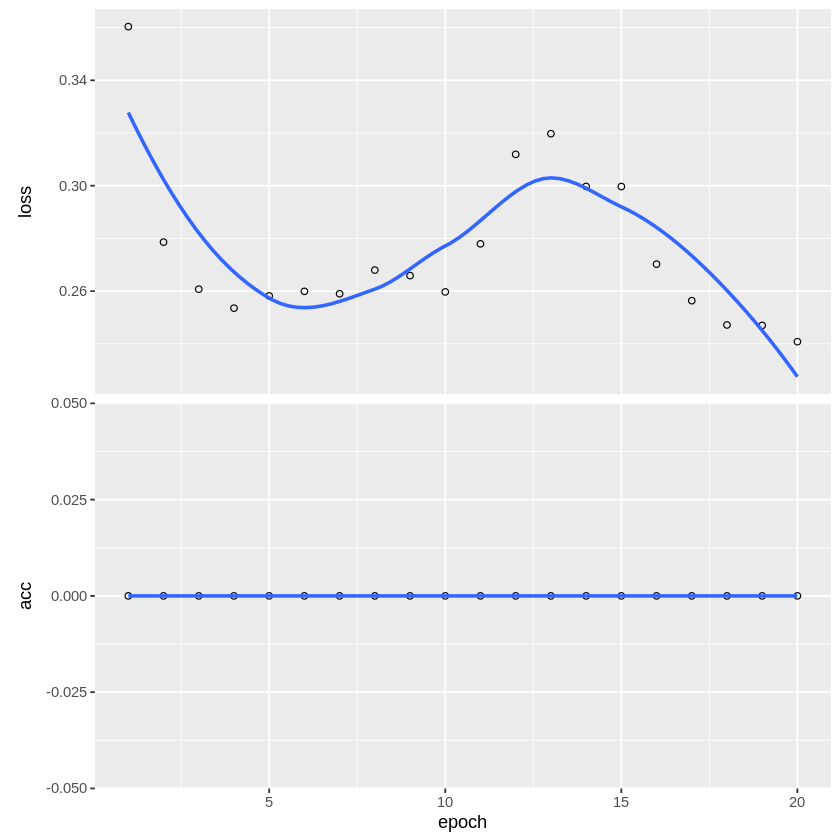

In [19]:
history <- lstm_model %>% fit(
  x = x_train_arr,
  y = y_train_arr,
  batch_size = 1,
  epochs = 20,
  verbose = 1,
  shuffle = FALSE
)

plot(history)

And perform the prediction:

In [20]:
lstm_forecast <- lstm_model %>%
  predict(x_pred_arr, batch_size = 1) %>%
  .[, , 1]

# we need to rescale the data to restore the original values
lstm_forecast <- lstm_forecast * scale_factors[2] + scale_factors[1]

Finally we check RMSE of the LSTM model and compare difference to ARIMA model

In [21]:
# evaluation
rmse(actual = test2[,2], predicted = lstm_forecast)

[1] 3548.223